In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.dielectron_mass import dielectron_mass
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [3]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_ucsd_mini, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = True
local = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'dielectron_mass'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples(year)

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'top'], year, redirector=redirector_ucsd_mini, small=True)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

meta = get_sample_meta(fileset, samples)

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress

    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)

    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.dask_executor


if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')
    
else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        dielectron_mass(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()
    

samples_2018.yaml


Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

KeyError: '/DYJetsToLL_M-5to50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM'

In [ ]:
output['totalEvents']['all']/1e6

In [ ]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_fine_bins   = hist.Bin('pt', r'$p_{T}\ (GeV)$', 300, 0, 300)
pt_rebin       = hist.Bin('pt', r'$p_{T}\ (GeV)$', 75, 0, 150)
eta_bins       = hist.Bin('eta', r'$\eta $', np.array([0, 0.8, 1.479, 2.5]))
eta_rebin      = hist.Bin('eta', r'$\eta $', 25, -2.5, 2.5)    
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)
mass_bins      = hist.Bin('mass', r'$mass (GeV/c^2)$', 50, 24, 124)


# define nicer labels and colors

nano_mappings = nano_mapping(year)

my_labels = {
    nano_mappings['TTW'][0]: 'ttW',
    nano_mappings['TTZ'][0]: 'ttZ',
    nano_mappings['DY'][0]: 'DY',
    nano_mappings['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mappings['TTW'][0]: '#8AC926',
    nano_mappings['TTZ'][0]: '#FFCA3A',
    nano_mappings['DY'][0]: '#6A4C93',
    nano_mappings['top'][0]: '#1982C4',
}


# 1D Histograms

In [ ]:
my_hist = scale_and_merge(output['N_ele'], meta, fileset, nano_mappings)


print(output['N_ele'].values())
# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['DY'][0], nano_mappings['top'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_testing_'+str(year)
        )


In [94]:
import re
histogram = my_hist.copy()
data=[]
signals=[]
omit=[]
bkg_sel  = re.compile('(?!(%s))'%('|'.join(data+signals+omit))) if len(data+signals+omit)>0 else re.compile('')

print(histogram[bkg_sel].integrate("dataset").values()[()])

hist.plot1d(histogram[bkg_sel], overlay="dataset", ax=ax, stack=True, overflow='over', clear=False, line_opts=None,
fill_opts={'edgecolor': (0,0,0,0.3),'alpha': 1.0},
order=[nano_mappings['DY'][0], nano_mappings['top'][0]], binwnorm=None)



[    0.             0.         10530.85204905     0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.        ]


KeyError: ()

In [56]:
from yahist import Hist1D, Hist2D

<AxesSubplot:>

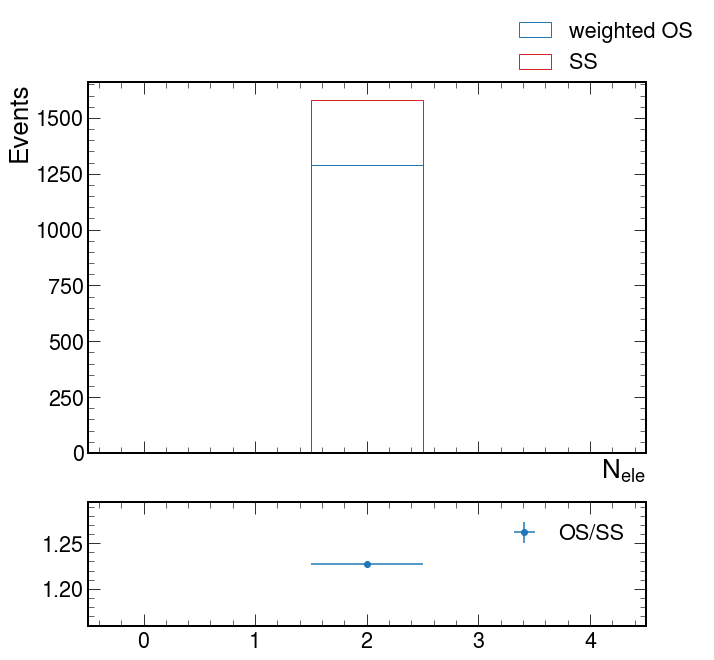

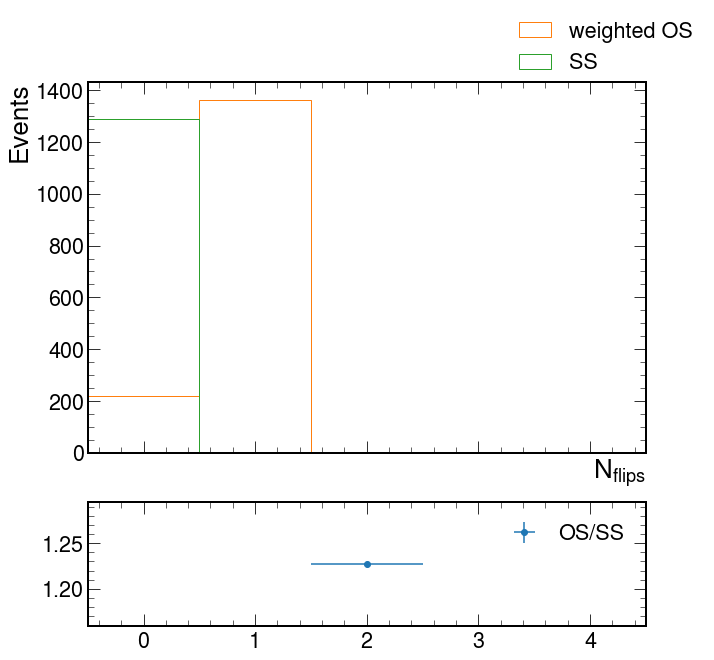

In [69]:
tmp1 = output['N_ele'].copy()
tmp1 = tmp1.rebin('multiplicity', N_bins_red)

tmp2 = output['N_ele2'].copy()
tmp2 = tmp2.rebin('multiplicity', N_bins_red)

tmp3 = output['electron_flips'].copy()
tmp3 = tmp3.rebin('multiplicity', N_bins_red)

tmp4 = output['electron_flips2'].copy()
tmp4 = tmp4.rebin('multiplicity', N_bins_red)


h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('multiplicity').edges()),
)

h2 = Hist1D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('multiplicity').edges()),
)


h3 = Hist1D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('multiplicity').edges()),
)

h4 = Hist1D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('multiplicity').edges()),
)

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h2.plot(ax=ax1, alpha=1, color="C0")
h1.plot(ax=ax1, alpha=1, color="C3")


ax1.set_xlabel(r'$N_{ele}$')
ax1.set_ylabel(r'Events')

fig.legend(["weighted OS", "SS"])

# Gaussian errors
#    (num/den).plot(ax=ax2,show_errors=True,label="ratio")
# Asymmetric Clopper-Pearson errors
h1.divide(h2, binomial=True).plot(ax=ax2, errors=True, label="OS/SS")

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3.plot(ax=ax1, alpha=1, color="C1")
h4.plot(ax=ax1, alpha=1, color="C2")


ax1.set_xlabel(r'$N_{flips}$')
ax1.set_ylabel(r'Events')

fig.legend(["weighted OS", "SS"])

# Gaussian errors
#    (num/den).plot(ax=ax2,show_errors=True,label="ratio")
# Asymmetric Clopper-Pearson errors
h1.divide(h2, binomial=True).plot(ax=ax2, errors=True, label="OS/SS")


In [70]:
print(tmp1.sum('dataset').values()[()].T)

[   0.            0.         1580.93737793    0.            0.        ]


(0.0, 2.0)

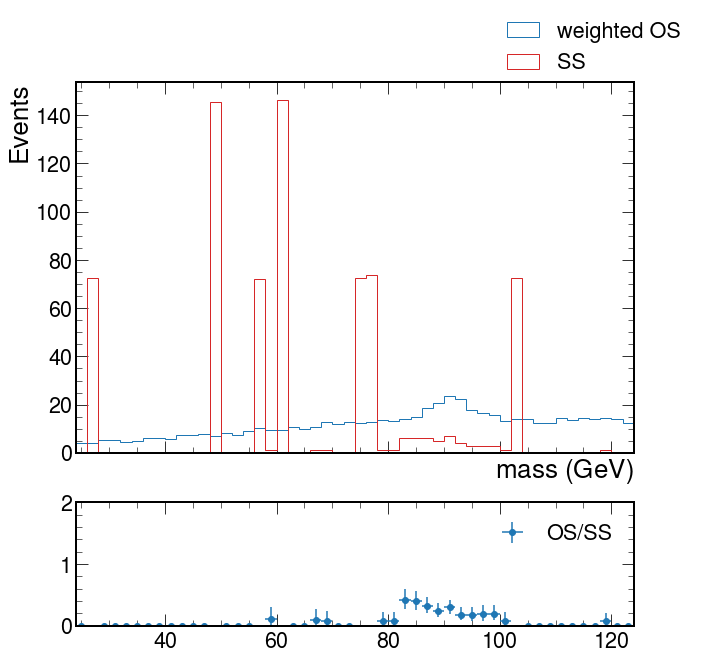

In [51]:
tmp1 = output['dilep_mass'].copy()
tmp1 = tmp1.rebin('mass', mass_bins)

tmp2 = output['dilep_mass2'].copy()
tmp2 = tmp2.rebin('mass', mass_bins)


h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('mass').edges()),
)

h2 = Hist1D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('mass').edges()),
)

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h2.plot(ax=ax1, alpha=1, color="C0")
h1.plot(ax=ax1, alpha=1, color="C3")


ax1.set_xlabel(r'$mass\ (GeV)$')
ax1.set_ylabel(r'Events')

fig.legend(["weighted OS", "SS"])

# Gaussian errors
#    (num/den).plot(ax=ax2,show_errors=True,label="ratio")
# Asymmetric Clopper-Pearson errors
h1.divide(h2, binomial=True).plot(ax=ax2, errors=True, label="OS/SS")
ax2.set_ylim([0,2])


<AxesSubplot:>

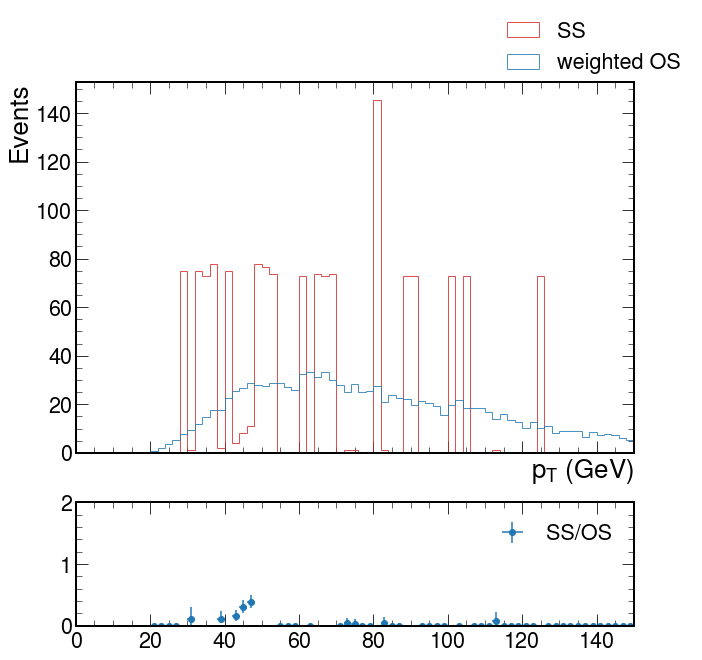

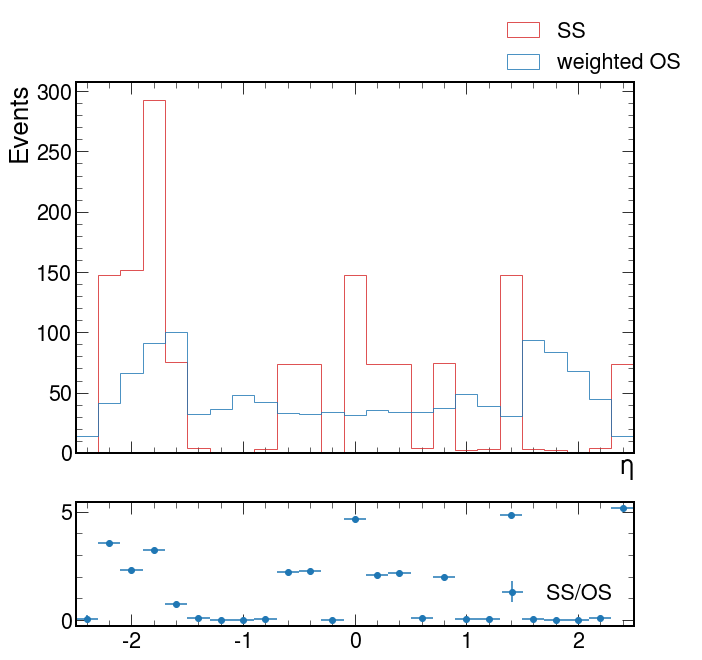

In [52]:
tmp1 = output['electron3'].copy()
tmp1 = tmp1.rebin('pt', pt_rebin)
tmp1 = tmp1.rebin('eta', eta_rebin)


tmp2 = output['electron4'].copy()
tmp2 = tmp2.rebin('pt', pt_rebin)
tmp2 = tmp2.rebin('eta', eta_rebin)


h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)

h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1.projection('x').plot(ax=ax1, alpha=0.8, color="C3")
h2.projection('x').plot(ax=ax1, alpha=0.8, color="C0")

fig.legend(["SS", "weighted OS"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h1.projection('x').divide(h2.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")
ax2.set_ylim([0,2])


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1.projection('y').plot(ax=ax1, alpha=0.8, color="C3")
h2.projection('y').plot(ax=ax1, alpha=0.8, color="C0")

fig.legend(["SS", "weighted OS"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h1.projection('y').divide(h2.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")